<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/UCI_dataset_classification_abalone_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install GPyOpt
!pip install GPy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83608 sha256=e2cebec0539609da084c4074e8ef3fe00d13a03ff7ed910481569389c8277d0a
  Stored in directory: /root/.cache/pip/wheels/5e/0b/6f/65b7572b74ce7c031e4c68556b8fd43c210f5b9415937c429d
  Created wheel for GPy: filename=GPy-1.10.0-cp38-cp38-linux_x86_64.whl size=3424731 sha256=06eb1e5e81f53a93b951c2de21aac29d5915239fec36ee2bdafbb85add07beee
  Stored in directory: /root/.cache/pip/wheels/48/b3/22/31f07cfd7b182ea3703151b7e5a7d6447e3e1ac6aa5c529413
  Created wheel 

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

In [3]:
#dataset = UCI Abalone https://archive.ics.uci.edu/ml/datasets/Abalone
with open("abalone.names") as f:
    print(f.read())

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour
      (Problem encoded as a classification task)

   -- Data set samp

In [9]:
#dataset = UCI Car Evaluation
names=['sex','length','diameter','height','w-weight','s-weight','v-weight','shell-weight','class']
df = pd.read_csv('abalone.data', names = names)
df.head()

,sex,length,diameter,height,w-weight,s-weight,v-weight,shell-weight,class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [10]:
#frequency distribution
for col in names: 
    print(df[col].value_counts())

#checking missing values
df.isnull().sum()

M    1528
I    1342
F    1307
Name: sex, dtype: int64
0.625    94
0.550    94
0.575    93
0.580    92
0.600    87
         ..
0.075     1
0.815     1
0.110     1
0.150     1
0.800     1
Name: length, Length: 134, dtype: int64
0.450    139
0.475    120
0.400    111
0.500    110
0.470    100
        ... 
0.610      1
0.650      1
0.620      1
0.095      1
0.615      1
Name: diameter, Length: 111, dtype: int64
0.150    267
0.140    220
0.155    217
0.175    211
0.160    205
0.125    202
0.165    193
0.135    189
0.145    182
0.130    169
0.120    169
0.170    160
0.100    145
0.110    135
0.115    133
0.180    131
0.090    124
0.105    114
0.185    103
0.190    103
0.095     91
0.195     78
0.080     76
0.085     74
0.200     68
0.075     61
0.070     47
0.205     45
0.065     39
0.215     31
0.060     26
0.055     25
0.210     23
0.050     18
0.220     17
0.040     13
0.225     13
0.045     11
0.230     10
0.030      6
0.035      6
0.235      6
0.025      5
0.240      4
0.250      3
0.02

sex             0
length          0
diameter        0
height          0
w-weight        0
s-weight        0
v-weight        0
shell-weight    0
class           0
dtype: int64

In [11]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])

df.head()
for col in names: 
    print(df[col].value_counts())

2    1528
1    1342
0    1307
Name: sex, dtype: int64
0.625    94
0.550    94
0.575    93
0.580    92
0.600    87
         ..
0.075     1
0.815     1
0.110     1
0.150     1
0.800     1
Name: length, Length: 134, dtype: int64
0.450    139
0.475    120
0.400    111
0.500    110
0.470    100
        ... 
0.610      1
0.650      1
0.620      1
0.095      1
0.615      1
Name: diameter, Length: 111, dtype: int64
0.150    267
0.140    220
0.155    217
0.175    211
0.160    205
0.125    202
0.165    193
0.135    189
0.145    182
0.130    169
0.120    169
0.170    160
0.100    145
0.110    135
0.115    133
0.180    131
0.090    124
0.105    114
0.185    103
0.190    103
0.095     91
0.195     78
0.080     76
0.085     74
0.200     68
0.075     61
0.070     47
0.205     45
0.065     39
0.215     31
0.060     26
0.055     25
0.210     23
0.050     18
0.220     17
0.040     13
0.225     13
0.045     11
0.230     10
0.030      6
0.035      6
0.235      6
0.025      5
0.240      4
0.250      3
0.02

In [12]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [13]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [16]:
#Random Forest classification

#max_features: 1 to around sqrt(# of features of dataset)
bounds = [
        {'name': 'max_features', 'type': 'continuous', 'domain': (1, 6)},
        {'name': 'n_estimators', 'type': 'continuous', 'domain': (1, 200)}
      ]

def rf_score(parameters):
  params = {
        'max_features':int(parameters[0][0]),
        'n_estimators':int(parameters[0][1])
    }
  
  clf = RandomForestClassifier(max_features=params['max_features'],n_estimators=params['n_estimators'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  print(params)
  print(score)
  return score

In [17]:
#RF Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

{'max_features': 4, 'n_estimators': 113}
0.2521225863761747
{'max_features': 4, 'n_estimators': 88}
0.24563443826265838
{'max_features': 2, 'n_estimators': 142}
0.24255224648183643
{'max_features': 3, 'n_estimators': 149}
0.24769624573378843
{'max_features': 1, 'n_estimators': 168}
0.2500783112814998
{'max_features': 4, 'n_estimators': 165}
0.2418684838000842
{'max_features': 1, 'n_estimators': 128}
0.2500853242320819
{'max_features': 1, 'n_estimators': 10}
0.22750596100799475
{'max_features': 4, 'n_estimators': 35}
0.2404986207863855
{'max_features': 3, 'n_estimators': 194}
0.2531640095376128
{'max_features': 3, 'n_estimators': 10}
0.22544298471176774
{'max_features': 4, 'n_estimators': 1}
0.1874713637851232
{'max_features': 1, 'n_estimators': 28}
0.24872481181915934
{'max_features': 1, 'n_estimators': 137}
0.2545397166767965
{'max_features': 1, 'n_estimators': 121}
0.2487177988685773
{'max_features': 1, 'n_estimators': 45}
0.2483823460657347
{'max_features': 1, 'n_estimators': 157}
0

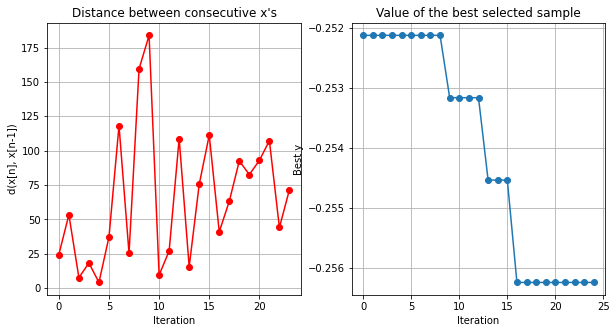

In [18]:
optimizer.plot_convergence()

In [19]:
rf_car = RandomForestClassifier(max_features=1,n_estimators=157)
rf_car.fit(X_train,y_train)
y_pred = rf_car.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.24880382775119617


{'max_features': 1, 'n_estimators': 74}
0.2435936696432746
{'max_features': 4, 'n_estimators': 153}
0.24837533311515264
{'max_features': 1, 'n_estimators': 33}
0.23982888400579738
{'max_features': 4, 'n_estimators': 58}
0.23743162373182475
{'max_features': 5, 'n_estimators': 154}
0.23913226424797793
{'max_features': 4, 'n_estimators': 60}
0.23878161671887416
{'max_features': 4, 'n_estimators': 13}
0.22375753892187572
{'max_features': 1, 'n_estimators': 65}
0.247005470101454
{'max_features': 1, 'n_estimators': 143}
0.24940623685071767
{'max_features': 1, 'n_estimators': 161}
0.25008181775679084
{'max_features': 1, 'n_estimators': 187}
0.25247907803076347
{'max_features': 1, 'n_estimators': 112}
0.25009233718266405
{'max_features': 1, 'n_estimators': 144}
0.2535064752910374
{'max_features': 1, 'n_estimators': 76}
0.2480176726354668
{'max_features': 1, 'n_estimators': 124}
0.25658632942166537
{'max_features': 1, 'n_estimators': 163}
0.25761489550703637
{'max_features': 1, 'n_estimators': 

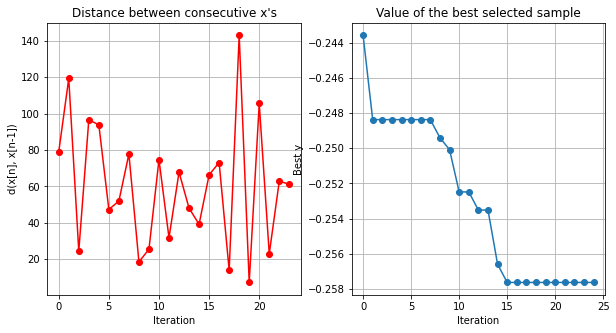

In [20]:
#RF classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [21]:
rf_car2 = RandomForestClassifier(max_features=1,n_estimators=163)
rf_car2.fit(X_train,y_train)
y_pred = rf_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.25996810207336524


In [22]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 0.1)}
      ]

def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  print(params)
  print(score)
  return score

In [23]:
#SVM Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

{'C': 0.3591372332134999, 'gamma': 0.010752694997241527}
0.16283954369068213
{'C': 0.9385089238968313, 'gamma': 0.0896578185714464}
0.21519355743606527
{'C': 0.7369045587126625, 'gamma': 0.07188559275844009}
0.2158714759923325
{'C': 0.24969767961307401, 'gamma': 0.03900192032197755}
0.18062789284211508
{'C': 0.9670877018748599, 'gamma': 0.05812038306482173}
0.21792276403758942
{'C': 1.0, 'gamma': 0.027555748487408056}
0.20835943709383326
{'C': 0.8392427340943247, 'gamma': 0.021543421056878884}
0.20287881621394174
{'C': 0.6635502887712112, 'gamma': 0.0545097680127859}
0.21040721866379916
{'C': 0.9499855717658123, 'gamma': 0.09246745050533478}
0.21519355743606527
{'C': 0.1, 'gamma': 0.06702940694619157}
0.16968067698349618
{'C': 0.714402338523613, 'gamma': 0.023667003987132663}
0.20117233157230352
{'C': 1.0, 'gamma': 0.017218643823852405}
0.20356374772079106
{'C': 0.899615938811593, 'gamma': 0.011171898264420853}
0.18097035859553975
{'C': 1.0, 'gamma': 0.04407059133283018}
0.215873813642

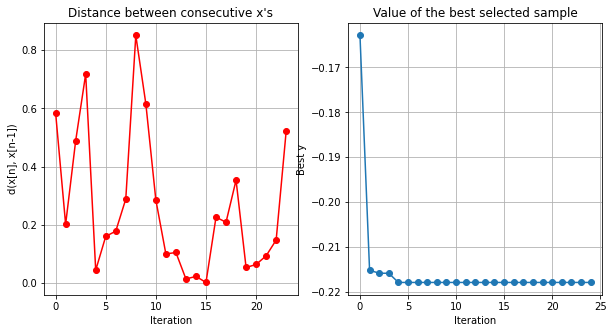

In [24]:
optimizer.plot_convergence()

In [25]:
SVM_car1 = svm.SVC(C=0.967,gamma=0.0581)
SVM_car1.fit(X_train,y_train)
y_pred = SVM_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.24322169059011164


{'C': 0.5152064699254263, 'gamma': 0.04377496783187352}
0.20733203983355933
{'C': 0.8920891971856111, 'gamma': 0.042068695947265415}
0.2121172097807284
{'C': 0.27716104200700714, 'gamma': 0.06574021351080228}
0.2049347795595867
{'C': 0.9958673112154796, 'gamma': 0.03708892070324642}
0.2107485155921268
{'C': 0.3310640137913999, 'gamma': 0.054264590650245415}
0.205617373416242
{'C': 0.8308713371514777, 'gamma': 0.05711538796644569}
0.21792276403758942
{'C': 0.8161384081242062, 'gamma': 0.09462205940035903}
0.21211487213053443
{'C': 0.8075258688831284, 'gamma': 0.040632492035464526}
0.2093809902286222
{'C': 0.8377361625076937, 'gamma': 0.02145336444710528}
0.20322128196736639
{'C': 0.8309142253493496, 'gamma': 0.04395103797188905}
0.21108981252045442
{'C': 0.8764134321389124, 'gamma': 0.04687314471186805}
0.21416849782598532
{'C': 0.9063677148606158, 'gamma': 0.05424489881432294}
0.21621394174575714
{'C': 0.9794926033841708, 'gamma': 0.06540101978655394}
0.21313174996493522
{'C': 1.0, 'ga

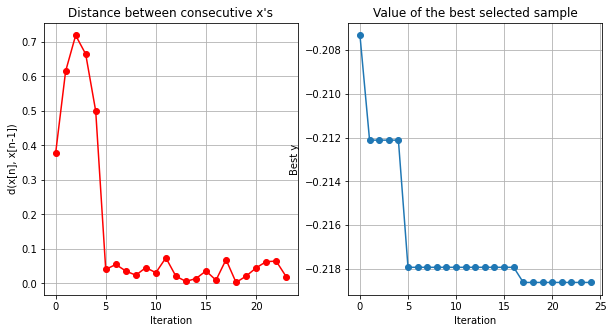

In [26]:
#SVM classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)

optimizer.plot_convergence()

In [27]:
SVM_car2 = svm.SVC(C=1,gamma=0.0917)
SVM_car2.fit(X_train,y_train)
y_pred = SVM_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.24641148325358853


In [28]:
#KNN Classification

#search domain
bounds = [ {'name': 'leaf_size', 'type': 'continuous', 'domain': (10, 50)},
        {'name': 'n_neighbors', 'type': 'discrete', 'domain': (3,4,5,6,7)}
      ]

def knn_score(parameters):
  params = {
        'leaf_size': parameters[0][0],
        'n_neighbors':int(parameters[0][1])
    }
  
  clf = KNeighborsClassifier(leaf_size=params['leaf_size'],n_neighbors=params['n_neighbors'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,10)
  print(params)
  print(score)
  return score

{'leaf_size': 37.42151471272473, 'n_neighbors': 3}
0.20939618495488338
{'leaf_size': 46.63928180911211, 'n_neighbors': 4}
0.21314460704100235
{'leaf_size': 24.195045421883105, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 14.14270086121451, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 36.669139041833866, 'n_neighbors': 5}
0.22203235307868527
{'leaf_size': 18.037483498306216, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 18.13540273981888, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 18.398549026473475, 'n_neighbors': 4}
0.21314460704100235
{'leaf_size': 24.323287042121603, 'n_neighbors': 5}
0.22203235307868527
{'leaf_size': 18.086912675487845, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 24.095593680857284, 'n_neighbors': 5}
0.22203235307868527
{'leaf_size': 14.206611978143542, 'n_neighbors': 4}
0.21314460704100235
{'leaf_size': 14.117736999306677, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 24.224714865849613, 'n_neighbors': 3}
0.20939618495488338
{'

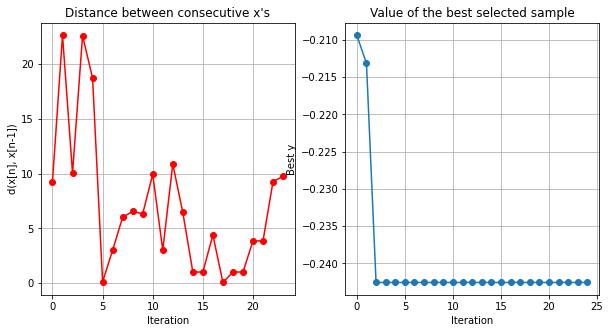

In [29]:
#KNN Classification - Matern52 kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()

In [30]:
KNN_car1 = KNeighborsClassifier(leaf_size=24,n_neighbors=7)
KNN_car1.fit(X_train,y_train)
y_pred = KNN_car1.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.24960127591706538


{'leaf_size': 12.06088539556701, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 35.757647539702646, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 41.52005378656783, 'n_neighbors': 4}
0.21314460704100235
{'leaf_size': 41.29077531791505, 'n_neighbors': 6}
0.2374327925569218
{'leaf_size': 34.73498121981538, 'n_neighbors': 6}
0.2374327925569218
{'leaf_size': 35.35301560383972, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 35.532512655123234, 'n_neighbors': 6}
0.2374327925569218
{'leaf_size': 35.59595337455363, 'n_neighbors': 4}
0.21314460704100235
{'leaf_size': 35.75764733039107, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 35.33000320811743, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 35.48414787668124, 'n_neighbors': 6}
0.2374327925569218
{'leaf_size': 35.80343739729029, 'n_neighbors': 7}
0.2425604282575155
{'leaf_size': 12.009483351342256, 'n_neighbors': 5}
0.22203235307868527
{'leaf_size': 12.089562271922205, 'n_neighbors': 6}
0.2374327925569218
{'leaf_size':

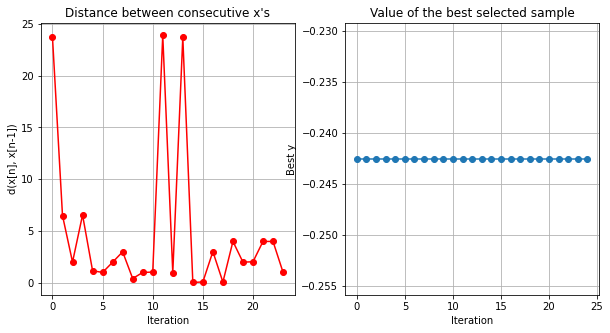

In [31]:
#KNN Classification - Matern52 + ExpQuad
kernel2 = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0) + GPy.kern.ExpQuad(input_dim=1,variance=1.0,lengthscale=1.0)
optimizer = GPyOpt.methods.BayesianOptimization(f=knn_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel2
                                                )

optimizer.run_optimization(max_iter=20)

#maximum accuracy score
acc_max=optimizer.fx_opt
#best parameters
params_best=optimizer.x_opt
print(acc_max)
print(params_best)
optimizer.plot_convergence()

In [32]:
KNN_car2 = KNeighborsClassifier(leaf_size=12,n_neighbors=7)
KNN_car2.fit(X_train,y_train)
y_pred = KNN_car2.predict(X_test)
accuracy_test = accuracy_score(y_pred,y_test)
print(accuracy_test)

0.24960127591706538
